Homework No. 4
Due 10/15 (11:00 pm), 2024 (150 points)

Objectives
1.	Apply Kernel SVM and MLP classification algorithms to the fashion-MNIST dataset
2.	Use k-fold cross validation to identify the best way to rescale and preprocess the data
3.	Use k-fold cross validation to identify the parameters that optimize performance (generalization) for each method.
4.	Compare the accuracy and identify correlation between the outputs of the two methods
Problem
For this homework, you will apply the following classification methods to the fashion-MNIST classification data  
1.	Kernel Support Vector Machines
2.	Multilayer Perceptrons
•	Apply 4-fold cross-validation to the provided training data subset to train your classifiers and identify their optimal parameters. You need to justify your choice of the optimal parameters by displaying and explaining plots of the train/validate accuracy versus the parameter. In addition to the classifier’s parameters (e.g. regularization, kernel, No. of layers/nodes, learning rate, etc.), you should also consider the following 3 ways to preprocess and rescale the data: 
a)	No preprocessing 
b)	StandardScaler
c)	MinMaxScaler
•	After fixing the classifiers’ parameters, apply each method to the provided testing data subset to predict and analyze your results. Compare the accuracy obtained during training to those of the test data and comment on the results (overfitting, underfitting, etc.) 
•	Analyze the correlation between the output of the 2 classifiers by displaying the predict_proba of SVM vs. predict_proba of MLP (using test data). Using these scatter plots (one per class), identify (if available) the following 3 groups
•	G-1: Samples that are easy to classify correctly by the SVM, but hard to classify by MLP
•	G-2: Samples that are easy to classify correctly by the MLP, but hard to classify by SVM
•	G-3: Samples that are hard to classify correctly by both methods
For each group, display few samples (as images) and identify any common features among them.
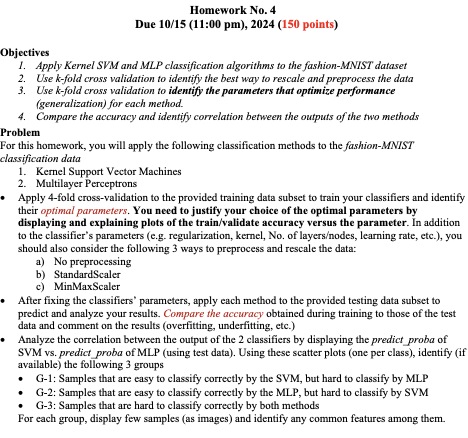

In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score

In [4]:
X_train = pd.read_csv('~/Desktop/Machine_Learning/dataset/X_rain.csv')
X_test = pd.read_csv('~/Desktop/Machine_Learning/dataset/X_test.csv')
y_train = pd.read_csv('~/Desktop/Machine_Learning/dataset/y_train.csv').values.ravel()
y_test = pd.read_csv('~/Desktop/Machine_Learning/dataset/y_test.csv').values.ravel()

In [5]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (9999, 784)
X_test shape: (4999, 784)
y_train shape: (9999,)
y_test shape: (4999,)


mini-Fashion-MNIST is a dataset composed of 10,000 samples for training and 5000 samples for testing.

Each of the two subsets contain small square 28×28 pixel grayscale images of items of 5 types of clothing. 

Features are pixel intensity (0-255).
The mapping of all 0-4 integers to class labels is: 
0: T-shirt/top 
1: Trouser 
2: Pullover 
3: Dress 
4: Coat 

The data is balanced: 2000 samples per class.


In [51]:
print(X_train.head())

   0  0.1  0.2  0.3  0.4  1  0.5  0.6  0.7  0.8  ...  119  114  130.1  76.1  \
0  0    0    0    0    0  0    0    0    0   22  ...    0    0      1     0   
1  0    0    0    0    0  0    0    0    0    0  ...    0    0      0     0   
2  0    0    0    0    0  0    0   11  142  200  ...  120  110    158    18   
3  0    0    0    0    0  0    0    0    0    0  ...   91   80     46     0   
4  0    0    0    0    0  0    0    0   58  121  ...   21   23     30    37   

   0.291  0.292  0.293  0.294  0.295  0.296  
0      0      0      0      0      0      0  
1      0      0      0      0      0      0  
2      0      3      0      0      0      0  
3      0      1      0      0      0      0  
4      0      0      1      0      0      0  

[5 rows x 784 columns]


In [52]:
print(X_test.head())

   0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8   52  ...  187.5  173.1  148  \
0  0    0    0    0    0    0    0    0    0   74  ...    105     15    0   
1  0    0    0    0    0    0    0    0    0    0  ...     34     33   14   
2  0    0    0    0    0    0    0    0    0   18  ...     54     51   63   
3  0    0    0    0    0    0    0   26   64  134  ...     41     41   37   
4  0    0    0    0    0    0    2    3    0    0  ...    107    123   72   

   0.302  0.303  1.17  0.304  0.305  0.306  0.307  
0      0      0     0      0      0      0      0  
1      0      1     0      0      0      0      0  
2     34      0     1      0      0      0      0  
3     35     36    36      0      0      0      0  
4      0      3     0      0      0      0      0  

[5 rows x 784 columns]


In [54]:
print(y_train[:5])

[0 0 0 0 0]


In [55]:
print(y_test[:5])

[0 0 0 0 0]


In [29]:
import seaborn as sns

parameters:
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']


scales: 
    'Unscaled': None,
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler()

kf = KFold(n_splits=4, shuffle=True, random_state=42)

In [59]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Initialize the SVC model with specified parameters
svc = SVC(kernel='rbf', C=0.01, gamma=0.001)

# Lists to store training accuracies, validation accuracies, and times
train_accuracies = []
val_accuracies = []
times_taken = []

# Perform cross-validation manually
for train_index, val_index in kf.split(X_train):
    # Use .iloc to index by row number for DataFrames
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Start timer
    start_time = time.time()

    # Fit the model
    svc.fit(X_train_fold, y_train_fold)

    # End timer and calculate time taken
    time_taken = time.time() - start_time
    times_taken.append(time_taken)

    # Calculate training accuracy
    train_accuracy = accuracy_score(y_train_fold, svc.predict(X_train_fold))
    train_accuracies.append(train_accuracy)

    # Calculate validation accuracy
    val_accuracy = accuracy_score(y_val_fold, svc.predict(X_val_fold))
    val_accuracies.append(val_accuracy)

# Calculate the average training accuracy, validation accuracy, and time taken
avg_train_accuracy = np.mean(train_accuracies)
avg_val_accuracy = np.mean(val_accuracies)
avg_time_taken = np.mean(times_taken)

# Print the results
print(f"Average Training Accuracy: {avg_train_accuracy:.4f}")
print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")
print(f"Average Time Taken: {avg_time_taken:.4f} seconds")

Average Training Accuracy: 0.2039
Average Validation Accuracy: 0.1883
Average Time Taken: 32.9248 seconds


In [60]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Parameter grids for C and gamma
C_values = [0.1, 1, 10]
gamma_values = [0.1, 1, 10]

# List to store results for each combination of C and gamma
results = []

# Loop through different values of C and gamma
for C in C_values:
    for gamma in gamma_values:
        print(f"Testing unscaled SVM with Kernal RBF  with C={C}, gamma={gamma}")

        # Initialize the SVC model with the current C and gamma
        svc = SVC(kernel='rbf', C=C, gamma=gamma)

        # Lists to store training accuracies, validation accuracies, and times
        train_accuracies = []
        val_accuracies = []
        times_taken = []

        # Perform cross-validation manually
        for train_index, val_index in kf.split(X_train):
            # Use .iloc to index by row number for DataFrames
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Start timer
            start_time = time.time()

            # Fit the model
            svc.fit(X_train_fold, y_train_fold)

            # End timer and calculate time taken
            time_taken = time.time() - start_time
            times_taken.append(time_taken)

            # Calculate training accuracy
            train_accuracy = accuracy_score(y_train_fold, svc.predict(X_train_fold))
            train_accuracies.append(train_accuracy)

            # Calculate validation accuracy
            val_accuracy = accuracy_score(y_val_fold, svc.predict(X_val_fold))
            val_accuracies.append(val_accuracy)

        # Calculate the average training accuracy, validation accuracy, and time taken
        avg_train_accuracy = np.mean(train_accuracies)
        avg_val_accuracy = np.mean(val_accuracies)
        avg_time_taken = np.mean(times_taken)

        # Print the results for this combination
        print(f"C={C}, gamma={gamma} -> Average Training Accuracy: {avg_train_accuracy:.4f}, "
              f"Average Validation Accuracy: {avg_val_accuracy:.4f}, "
              f"Average Time Taken: {avg_time_taken:.4f} seconds\n")

        # Store the results for this combination in the results list
        results.append({
            'C': C,
            'gamma': gamma,
            'avg_train_accuracy': avg_train_accuracy,
            'avg_val_accuracy': avg_val_accuracy,
            'avg_time_taken': avg_time_taken
        })

# You can convert the results to a DataFrame for easy analysis if needed
results_df = pd.DataFrame(results)

# Print the results DataFrame
print(results_df)

Testing SVM with C=0.1, gamma=0.1
C=0.1, gamma=0.1 -> Average Training Accuracy: 0.2039, Average Validation Accuracy: 0.1883, Average Time Taken: 32.8184 seconds

Testing SVM with C=0.1, gamma=1
C=0.1, gamma=1 -> Average Training Accuracy: 0.2039, Average Validation Accuracy: 0.1883, Average Time Taken: 36.5434 seconds

Testing SVM with C=0.1, gamma=10
C=0.1, gamma=10 -> Average Training Accuracy: 0.2039, Average Validation Accuracy: 0.1883, Average Time Taken: 33.0848 seconds

Testing SVM with C=1, gamma=0.1
C=1, gamma=0.1 -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.1883, Average Time Taken: 33.1585 seconds

Testing SVM with C=1, gamma=1
C=1, gamma=1 -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.1883, Average Time Taken: 33.2269 seconds

Testing SVM with C=1, gamma=10
C=1, gamma=10 -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.1883, Average Time Taken: 33.3337 seconds

Testing SVM with C=10, gamma=0.1
C=10, gamma=0

In [6]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Parameter grids for C and gamma
C_values = [.01, 0.1, 1, 10]
gamma_values = [.01, 0.1, 1, 10]

# List to store results for each combination of C and gamma
results = []

# Loop through different values of C and gamma
for C in C_values:
    for gamma in gamma_values:
        print(f"Testing unscaled SVM with kernal poly with C={C}, gamma={gamma}")

        # Initialize the SVC model with the current C and gamma
        svc = SVC(kernel='poly', C=C, gamma=gamma)

        # Lists to store training accuracies, validation accuracies, and times
        train_accuracies = []
        val_accuracies = []
        times_taken = []

        # Perform cross-validation manually
        for train_index, val_index in kf.split(X_train):
            # Use .iloc to index by row number for DataFrames
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Start timer
            start_time = time.time()

            # Fit the model
            svc.fit(X_train_fold, y_train_fold)

            # End timer and calculate time taken
            time_taken = time.time() - start_time
            times_taken.append(time_taken)

            # Calculate training accuracy
            train_accuracy = accuracy_score(y_train_fold, svc.predict(X_train_fold))
            train_accuracies.append(train_accuracy)

            # Calculate validation accuracy
            val_accuracy = accuracy_score(y_val_fold, svc.predict(X_val_fold))
            val_accuracies.append(val_accuracy)

        # Calculate the average training accuracy, validation accuracy, and time taken
        avg_train_accuracy = np.mean(train_accuracies)
        avg_val_accuracy = np.mean(val_accuracies)
        avg_time_taken = np.mean(times_taken)

        # Print the results for this combination
        print(f"C={C}, gamma={gamma} -> Average Training Accuracy: {avg_train_accuracy:.4f}, "
              f"Average Validation Accuracy: {avg_val_accuracy:.4f}, "
              f"Average Time Taken: {avg_time_taken:.4f} seconds\n")

        # Store the results for this combination in the results list
        results.append({
            'C': C,
            'gamma': gamma,
            'avg_train_accuracy': avg_train_accuracy,
            'avg_val_accuracy': avg_val_accuracy,
            'avg_time_taken': avg_time_taken
        })

# You can convert the results to a DataFrame for easy analysis if needed
results_df = pd.DataFrame(results)

# Print the results DataFrame
print(results_df)

Testing poly SVM with C=0.01, gamma=0.01
C=0.01, gamma=0.01 -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8721, Average Time Taken: 3.7652 seconds

Testing poly SVM with C=0.01, gamma=0.1
C=0.01, gamma=0.1 -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8722, Average Time Taken: 3.7304 seconds

Testing poly SVM with C=0.01, gamma=1
C=0.01, gamma=1 -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8722, Average Time Taken: 3.6876 seconds

Testing poly SVM with C=0.01, gamma=10
C=0.01, gamma=10 -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8721, Average Time Taken: 3.7806 seconds

Testing poly SVM with C=0.1, gamma=0.01
C=0.1, gamma=0.01 -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8721, Average Time Taken: 3.8005 seconds

Testing poly SVM with C=0.1, gamma=0.1
C=0.1, gamma=0.1 -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8722, Average Time Taken: 3.7622 s

In [8]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Parameter grids for C and gamma
C_values = [0.01, 0.1, 1, 10]
gamma_values = [0.01, 0.1, 1, 10]

# Function to scale only X_train
def scale_data(X_train, scaler):
    X_train_scaled = scaler.fit_transform(X_train)
    return X_train_scaled

# List of scalers: MinMaxScaler and StandardScaler
scalers = {
    'MinMaxScaler': MinMaxScaler(),
    'StandardScaler': StandardScaler()
}

# Loop through the scalers (MinMaxScaler and StandardScaler)
for scaler_name, scaler in scalers.items():
    print(f"\nRunning with {scaler_name}...\n")
    
    # Scale X_train only (no need to scale X_test for cross-validation)
    X_train_scaled = scale_data(X_train, scaler)

    # List to store results for each combination of C and gamma
    results = []

    # Test with polynomial kernel (since you observed performance improvements here)
    for C in C_values:
        for gamma in gamma_values:
            print(f"Testing SVM with poly kernal with C={C}, gamma={gamma}, using {scaler_name}")

            # Initialize the SVC model with the current C and gamma for polynomial kernel
            svc = SVC(kernel='poly', C=C, gamma=gamma)

            # Lists to store training accuracies, validation accuracies, and times
            train_accuracies = []
            val_accuracies = []
            times_taken = []

            # Perform cross-validation manually
            for train_index, val_index in kf.split(X_train_scaled):
                # Split the scaled training data
                X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
                y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

                # Start timer
                start_time = time.time()

                # Fit the model
                svc.fit(X_train_fold, y_train_fold)

                # End timer and calculate time taken
                time_taken = time.time() - start_time
                times_taken.append(time_taken)

                # Calculate training accuracy
                train_accuracy = accuracy_score(y_train_fold, svc.predict(X_train_fold))
                train_accuracies.append(train_accuracy)

                # Calculate validation accuracy
                val_accuracy = accuracy_score(y_val_fold, svc.predict(X_val_fold))
                val_accuracies.append(val_accuracy)

            # Calculate the average training accuracy, validation accuracy, and time taken
            avg_train_accuracy = np.mean(train_accuracies)
            avg_val_accuracy = np.mean(val_accuracies)
            avg_time_taken = np.mean(times_taken)

            # Print the results for this combination
            print(f"C={C}, gamma={gamma} -> Average Training Accuracy: {avg_train_accuracy:.4f}, "
                  f"Average Validation Accuracy: {avg_val_accuracy:.4f}, "
                  f"Average Time Taken: {avg_time_taken:.4f} seconds\n")

            # Store the results for this combination in the results list
            results.append({
                'scaler': scaler_name,
                'C': C,
                'gamma': gamma,
                'avg_train_accuracy': avg_train_accuracy,
                'avg_val_accuracy': avg_val_accuracy,
                'avg_time_taken': avg_time_taken
            })

    # Convert the results to a DataFrame for easy analysis
    results_df = pd.DataFrame(results)

    # Print the results DataFrame
    print(f"\nResults for {scaler_name}:\n")
    print(results_df)


Running with MinMaxScaler...

Testing poly SVM with C=0.01, gamma=0.01, using MinMaxScaler
C=0.01, gamma=0.01 -> Average Training Accuracy: 0.7969, Average Validation Accuracy: 0.7913, Average Time Taken: 13.6423 seconds

Testing poly SVM with C=0.01, gamma=0.1, using MinMaxScaler
C=0.01, gamma=0.1 -> Average Training Accuracy: 0.9842, Average Validation Accuracy: 0.8801, Average Time Taken: 4.6874 seconds

Testing poly SVM with C=0.01, gamma=1, using MinMaxScaler
C=0.01, gamma=1 -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8723, Average Time Taken: 3.6589 seconds

Testing poly SVM with C=0.01, gamma=10, using MinMaxScaler
C=0.01, gamma=10 -> Average Training Accuracy: 1.0000, Average Validation Accuracy: 0.8723, Average Time Taken: 3.6730 seconds

Testing poly SVM with C=0.1, gamma=0.01, using MinMaxScaler
C=0.1, gamma=0.01 -> Average Training Accuracy: 0.8636, Average Validation Accuracy: 0.8466, Average Time Taken: 24.7259 seconds

Testing poly SVM with C=0.

In [ ]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Parameter grids for C and gamma
C_values = [0.01, 0.1, 1]
gamma_values = [0.01, 0.1, 1]

# Function to scale only X_train
def scale_data(X_train, scaler):
    X_train_scaled = scaler.fit_transform(X_train)
    return X_train_scaled

# List of scalers: MinMaxScaler and StandardScaler
scalers = {
    'MinMaxScaler': MinMaxScaler(),
    'StandardScaler': StandardScaler()
}

# Loop through the scalers (MinMaxScaler and StandardScaler)
for scaler_name, scaler in scalers.items():
    print(f"\nRunning with {scaler_name}...\n")
    
    # Scale X_train only (no need to scale X_test for cross-validation)
    X_train_scaled = scale_data(X_train, scaler)

    # List to store results for each combination of C and gamma
    results = []

    # Test with polynomial kernel (since you observed performance improvements here)
    for C in C_values:
        for gamma in gamma_values:
            print(f"Testing SVM with rbf kernal with C={C}, gamma={gamma}, using {scaler_name}")

            # Initialize the SVC model with the current C and gamma for polynomial kernel
            svc = SVC(kernel='rbf', C=C, gamma=gamma)

            # Lists to store training accuracies, validation accuracies, and times
            train_accuracies = []
            val_accuracies = []
            times_taken = []

            # Perform cross-validation manually
            for train_index, val_index in kf.split(X_train_scaled):
                # Split the scaled training data
                X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
                y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

                # Start timer
                start_time = time.time()

                # Fit the model
                svc.fit(X_train_fold, y_train_fold)

                # End timer and calculate time taken
                time_taken = time.time() - start_time
                times_taken.append(time_taken)

                # Calculate training accuracy
                train_accuracy = accuracy_score(y_train_fold, svc.predict(X_train_fold))
                train_accuracies.append(train_accuracy)

                # Calculate validation accuracy
                val_accuracy = accuracy_score(y_val_fold, svc.predict(X_val_fold))
                val_accuracies.append(val_accuracy)

            # Calculate the average training accuracy, validation accuracy, and time taken
            avg_train_accuracy = np.mean(train_accuracies)
            avg_val_accuracy = np.mean(val_accuracies)
            avg_time_taken = np.mean(times_taken)

            # Print the results for this combination
            print(f"C={C}, gamma={gamma} -> Average Training Accuracy: {avg_train_accuracy:.4f}, "
                  f"Average Validation Accuracy: {avg_val_accuracy:.4f}, "
                  f"Average Time Taken: {avg_time_taken:.4f} seconds\n")

            # Store the results for this combination in the results list
            results.append({
                'scaler': scaler_name,
                'C': C,
                'gamma': gamma,
                'avg_train_accuracy': avg_train_accuracy,
                'avg_val_accuracy': avg_val_accuracy,
                'avg_time_taken': avg_time_taken
            })

    # Convert the results to a DataFrame for easy analysis
    results_df = pd.DataFrame(results)

    # Print the results DataFrame
    print(f"\nResults for {scaler_name}:\n")
    print(results_df)


Running with MinMaxScaler...

Testing SVM with rbf kernal with C=0.01, gamma=0.01, using MinMaxScaler
C=0.01, gamma=0.01 -> Average Training Accuracy: 0.7854, Average Validation Accuracy: 0.7836, Average Time Taken: 23.0081 seconds

Testing SVM with rbf kernal with C=0.01, gamma=0.1, using MinMaxScaler
C=0.01, gamma=0.1 -> Average Training Accuracy: 0.2925, Average Validation Accuracy: 0.2772, Average Time Taken: 49.7230 seconds

Testing SVM with rbf kernal with C=0.01, gamma=1, using MinMaxScaler
C=0.01, gamma=1 -> Average Training Accuracy: 0.2039, Average Validation Accuracy: 0.1883, Average Time Taken: 33.5535 seconds

Testing SVM with rbf kernal with C=0.01, gamma=10, using MinMaxScaler
C=0.01, gamma=10 -> Average Training Accuracy: 0.2039, Average Validation Accuracy: 0.1883, Average Time Taken: 34.3083 seconds

Testing SVM with rbf kernal with C=0.1, gamma=0.01, using MinMaxScaler
C=0.1, gamma=0.01 -> Average Training Accuracy: 0.8607, Average Validation Accuracy: 0.8546, Avera

In [ ]:
rbf_unscaled_df = pd.DataFrame({
    'C': [0.1, 0.1, 0.1, 1.0, 1.0, 1.0, 10.0, 10.0, 10.0],
    'gamma': [0.1, 1.0, 10.0, 0.1, 1.0, 10.0, 0.1, 1.0, 10.0],
    'avg_train_accuracy': [0.203887, 0.203887, 0.203887, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000],
    'avg_val_accuracy': [0.188319, 0.188319, 0.188319, 0.188319, 0.188319, 0.188319, 0.188319, 0.188319, 0.188319],
    'avg_time_taken': [32.81, 36.54, 33.08, 33.16, 33.22, 33.33, 33.36, 33.34, 33.37]
})

# Unscaled results for Polynomial (example)
poly_unscaled_df = pd.DataFrame({
    'C': [0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 1.0, 1.0, 1.0, 10.0, 10.0, 10.0],
    'gamma': [0.01, 0.1, 1.0, 0.01, 0.1, 1.0, 0.01, 0.1, 1.0, 0.01, 0.1, 1.0],
    'avg_train_accuracy': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    'avg_val_accuracy': [0.8721, 0.8721, 0.8721, 0.8721, 0.8721, 0.8721, 0.8721, 0.8721, 0.8721, 0.8721, 0.8721, 0.8721],
    'avg_time_taken': [3.78, 3.73, 3.68, 3.80, 3.76, 3.81, 3.78, 3.79, 3.78, 3.79, 3.80, 3.79]
})

In [ ]:
def plot_results(df, title):
    plt.figure(figsize=(12, 8))
    
    # Plot average training and validation accuracy
    plt.subplot(2, 1, 1)
    sns.lineplot(data=df, x='C', y='avg_train_accuracy', hue='gamma', marker='o', label='Train Accuracy', palette='Set1')
    sns.lineplot(data=df, x='C', y='avg_val_accuracy', hue='gamma', marker='o', label='Validation Accuracy', palette='Set2')
    plt.title(f'Average Training and Validation Accuracy ({title})')
    plt.ylabel('Accuracy')
    plt.xscale('log')
    plt.legend(title='Gamma Values')
    plt.grid(True)

    # Plot average time taken
    plt.subplot(2, 1, 2)
    sns.lineplot(data=df, x='C', y='avg_time_taken', hue='gamma', marker='o', palette='Set1')
    plt.title(f'Average Time Taken ({title})')
    plt.ylabel('Time (seconds)')
    plt.xscale('log')
    plt.legend(title='Gamma Values')
    plt.grid(True)

    # Show the plots
    plt.tight_layout()
    plt.show()

# MinMaxScaler results
minmax_df = pd.DataFrame({
    'C': [0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 1.0, 1.0, 1.0, 1.0, 10.0, 10.0, 10.0, 10.0],
    'gamma': [0.01, 0.1, 1.0, 10.0, 0.01, 0.1, 1.0, 10.0, 0.01, 0.1, 1.0, 10.0, 0.01, 0.1, 1.0, 10.0],
    'avg_train_accuracy': [0.796913, 0.984232, 1.000000, 1.000000, 0.863620, 0.998166, 1.000000, 1.000000, 0.924792, 0.999900, 1.000000, 1.000000, 0.984232, 1.000000, 1.000000, 1.000000],
    'avg_val_accuracy': [0.791280, 0.880087, 0.872287, 0.872287, 0.846584, 0.880887, 0.872287, 0.872287, 0.876186, 0.877988, 0.872287, 0.872287, 0.880087, 0.872287, 0.872287, 0.872287],
    'avg_time_taken': [13.642346, 4.687351, 3.658906, 3.672971, 24.725939, 4.049554, 3.690097, 3.679133, 5.812937, 3.738050, 107.652860, 3.691382, 4.702492, 3.663396, 3.670600, 3.682496]
})

# StandardScaler results
standard_df = pd.DataFrame({
    'C': [0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 1.0, 1.0, 1.0, 1.0, 10.0, 10.0, 10.0, 10.0],
    'gamma': [0.01, 0.1, 1.0, 10.0, 0.01, 0.1, 1.0, 10.0, 0.01, 0.1, 1.0, 10.0, 0.01, 0.1, 1.0, 10.0],
    'avg_train_accuracy': [0.97103, 1.00000, 1.00000, 1.00000, 0.99940, 1.00000, 1.00000, 1.00000, 1.00000, 1.00000, 1.00000, 1.00000, 1.00000, 1.00000, 1.00000, 1.00000],
    'avg_val_accuracy': [0.896590, 0.894489, 0.894489, 0.894489, 0.896590, 0.894489, 0.894489, 0.894489, 0.894489, 0.894489, 0.894489, 0.894489, 0.894489, 0.894489, 0.894489, 0.894489],
    'avg_time_taken': [6.955760, 6.453611, 6.502625, 6.516308, 6.559425, 6.502808, 6.499614, 6.533026, 6.516806, 6.560819, 6.491585, 6.501079, 6.512503, 6.506678, 6.506780, 6.512290]
})

# Plot results for MinMaxScaler
plot_results(minmax_df, "Polynomial SVM with MinMaxScaler")

# Plot results for StandardScaler
plot_results(standard_df, "Polynomial SVM with StandardScaler")

In [ ]:
def plot_results_with_unscaled(df_scaled, df_unscaled, title):
    plt.figure(figsize=(12, 8))

    # Plot average training and validation accuracy
    plt.subplot(2, 1, 1)
    # Unscaled data
    sns.lineplot(data=df_unscaled, x='C', y='avg_train_accuracy', hue='gamma', marker='o', label='Train Accuracy (Unscaled)', palette='coolwarm')
    sns.lineplot(data=df_unscaled, x='C', y='avg_val_accuracy', hue='gamma', marker='o', label='Validation Accuracy (Unscaled)', palette='cool')
    
    # Scaled data
    sns.lineplot(data=df_scaled, x='C', y='avg_train_accuracy', hue='gamma', marker='o', label='Train Accuracy (Scaled)', palette='Set1')
    sns.lineplot(data=df_scaled, x='C', y='avg_val_accuracy', hue='gamma', marker='o', label='Validation Accuracy (Scaled)', palette='Set2')
    
    plt.title(f'Average Training and Validation Accuracy ({title})')
    plt.ylabel('Accuracy')
    plt.xscale('log')
    plt.legend(title='Gamma Values')
    plt.grid(True)

    # Plot average time taken
    plt.subplot(2, 1, 2)
    # Unscaled data
    sns.lineplot(data=df_unscaled, x='C', y='avg_time_taken', hue='gamma', marker='o', label='Time Taken (Unscaled)', palette='coolwarm')
    
    # Scaled data
    sns.lineplot(data=df_scaled, x='C', y='avg_time_taken', hue='gamma', marker='o', label='Time Taken (Scaled)', palette='Set1')
    
    plt.title(f'Average Time Taken ({title})')
    plt.ylabel('Time (seconds)')
    plt.xscale('log')
    plt.legend(title='Gamma Values')
    plt.grid(True)

    # Show the plots
    plt.tight_layout()
    plt.show()

# Plot results for Polynomial SVM with MinMaxScaler vs Unscaled
plot_results_with_unscaled(minmax_df, poly_unscaled_df, "Polynomial SVM with MinMaxScaler vs Unscaled")

# Plot results for Polynomial SVM with StandardScaler vs Unscaled
plot_results_with_unscaled(standard_df, poly_unscaled_df, "Polynomial SVM with StandardScaler vs Unscaled")

# Plot results for RBF SVM with MinMaxScaler vs Unscaled
plot_results_with_unscaled(minmax_df, rbf_unscaled_df, "RBF SVM with MinMaxScaler vs Unscaled")

# Plot results for RBF SVM with StandardScaler vs Unscaled
plot_results_with_unscaled(standard_df, rbf_unscaled_df, "RBF SVM with StandardScaler vs Unscaled")

# Results for MinMaxScaler (RBF Kernel)
rbf_minmax_df = pd.DataFrame({
    'C': [0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 1.0, 1.0, 1.0, 1.0, 10.0, 10.0, 10.0, 10.0],
    'gamma': [0.01, 0.1, 1.0, 10.0, 0.01, 0.1, 1.0, 10.0, 0.01, 0.1, 1.0, 10.0, 0.01, 0.1, 1.0, 10.0],
    'avg_train_accuracy': [0.785445, 0.292463, 0.203887, 0.203887, 0.860686, 0.843284, 0.203887, 0.203887, 0.921959, 0.994099, 1.000000, 1.000000, 0.984899, 1.000000, 1.000000, 1.000000],
    'avg_val_accuracy': [0.783578, 0.277228, 0.188319, 0.188319, 0.854585, 0.778878, 0.188319, 0.188319, 0.895389, 0.882688, 0.274227, 0.188519, 0.906590, 0.886388, 0.294129, 0.188519],
    'avg_time_taken': [23.008085, 49.722987, 33.553515, 34.308282, 9.411522, 24.406856, 34.227162, 34.988520, 5.702963, 23.118198, 34.708789, 46.967912, 5.047071, 23.097557, 37.824980, 41.536860]
})

# Plot RBF Kernel Results for MinMaxScaler
plot_results_with_unscaled(rbf_minmax_df, rbf_unscaled_df, "RBF SVM with MinMaxScaler vs Unscaled")


In [ ]:
# Results for MinMaxScaler (RBF Kernel)
rbf_minmax_df = pd.DataFrame({
    'C': [0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 1.0, 1.0, 1.0, 1.0, 10.0, 10.0, 10.0, 10.0],
    'gamma': [0.01, 0.1, 1.0, 10.0, 0.01, 0.1, 1.0, 10.0, 0.01, 0.1, 1.0, 10.0, 0.01, 0.1, 1.0, 10.0],
    'avg_train_accuracy': [0.785445, 0.292463, 0.203887, 0.203887, 0.860686, 0.843284, 0.203887, 0.203887, 0.921959, 0.994099, 1.000000, 1.000000, 0.984899, 1.000000, 1.000000, 1.000000],
    'avg_val_accuracy': [0.783578, 0.277228, 0.188319, 0.188319, 0.854585, 0.778878, 0.188319, 0.188319, 0.895389, 0.882688, 0.274227, 0.188519, 0.906590, 0.886388, 0.294129, 0.188519],
    'avg_time_taken': [23.008085, 49.722987, 33.553515, 34.308282, 9.411522, 24.406856, 34.227162, 34.988520, 5.702963, 23.118198, 34.708789, 46.967912, 5.047071, 23.097557, 37.824980, 41.536860]
})

# Plot RBF Kernel Results for MinMaxScaler
plot_results_with_unscaled(rbf_minmax_df, rbf_unscaled_df, "RBF SVM with MinMaxScaler vs Unscaled")
